# 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import keras
import os 
import warnings
warnings.filterwarnings('ignore')

# 2. Import Dataset

In [2]:
X1 = pd.read_csv("X1.csv")
X1.drop(columns = ["Unnamed: 0"], inplace=True)
Y1 = pd.read_csv("Y1.csv", header = None, names = ["revenue"])
Y1["revenue"] = np.log(Y1["revenue"])

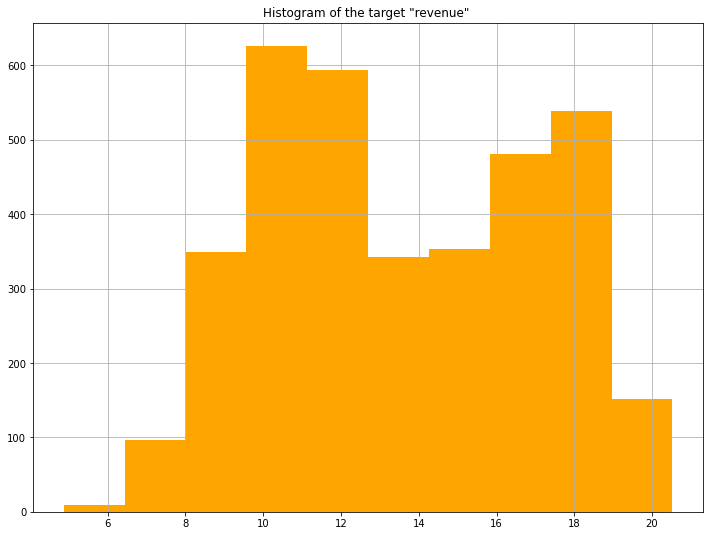

In [3]:
plt.figure(figsize = (12,9))
plt.hist(Y1[Y1["revenue"] < 1e7].values, color = "orange")
plt.grid()
plt.title("Histogram of the target \"revenue\" ")
plt.savefig(os.path.join("./figures/", "Histogram_target_low.svg"))
plt.show()

# 3. First Prediction

## 3.1 Features Engineering

In [4]:
# Removing Multiple occurences of a film

print(len(X1["title"].values))
print(len(np.unique(X1["title"].values)))
X1 = X1[~X1["title"].duplicated(keep="first")]
#Y1 = Y1.iloc[X1.index]

3540
3106


In [5]:
# Drop NaN values (that are stored as \\N)
for col in X1.columns : 
    X1.drop(X1[X1[col] == "\\N"].index, inplace=True)
    
    
# Here only some relevant features at first sight evaluation will be kept => mainly the numerical features
features = ["ratings", "n_votes", "is_adult", "production_year", "runtime", "genres", "release_year"]
df1 = X1[features]

df1.reset_index(inplace=True)

for i in range(len(df1)) :
    df1["runtime"][i] = int(df1.iloc[i]["runtime"])


In [6]:
# Actually genres is a categorical feature => Need to be transformed in a numerical one

lst_genres = list()

for i in range(len(df1["genres"])) :
    lst_genres += df1["genres"].loc[i].split(",")

In [7]:
np.unique(lst_genres)

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller',
       'War', 'Western'], dtype='<U11')

In [8]:
cat_genre = np.unique(lst_genres)
df1[cat_genre] = 0 # initialize empty columns

for i in range(len(df1)) :
    genre = df1["genres"][i]
    genre = genre.split(",")
    for j in genre :
        df1[j][i] = 1

df1.drop(columns = ["genres"], inplace=True)

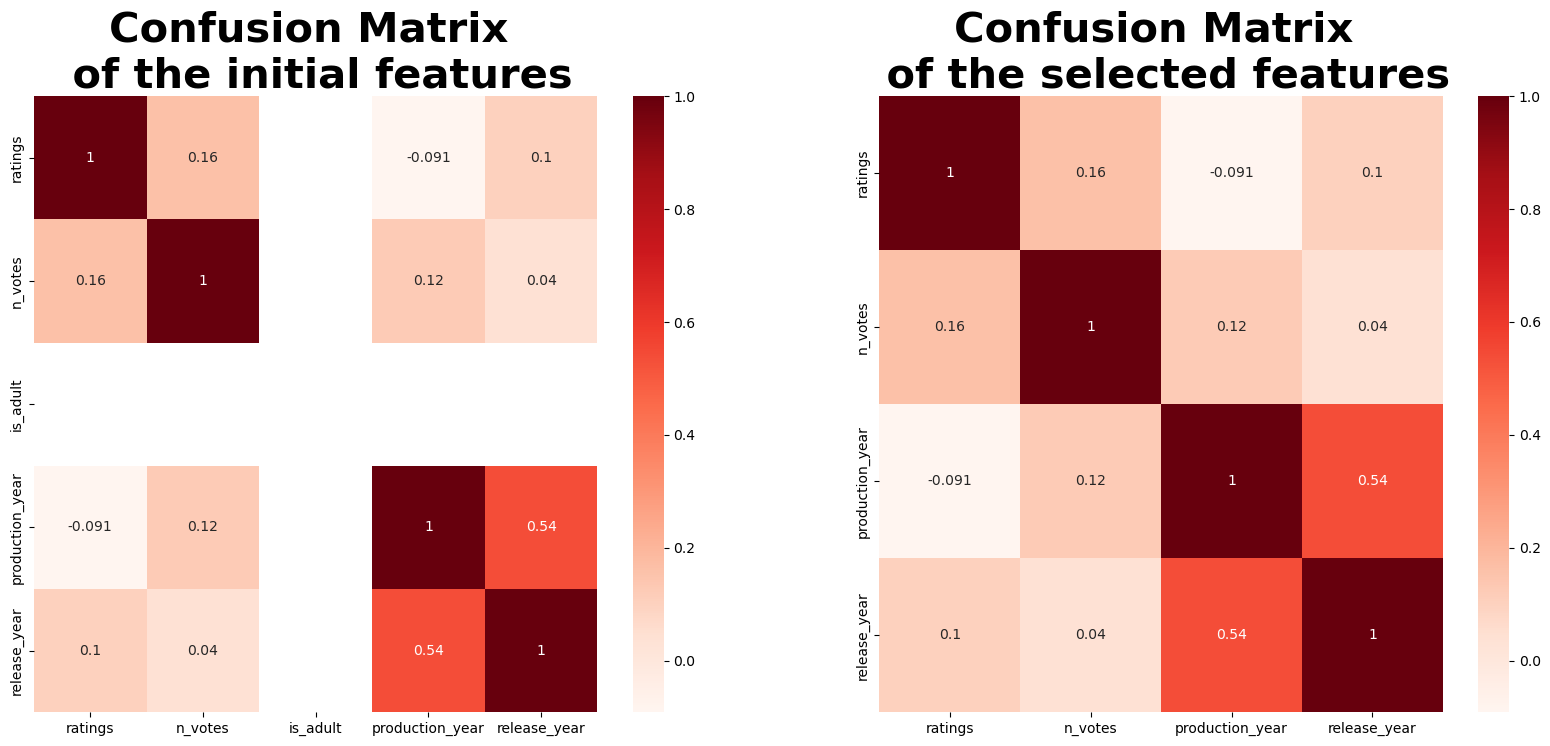

In [9]:
matplotlib.style.use("default")
plt.figure(figsize=(20,8))
plt.subplot(121)
corr = X1.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title("Confusion Matrix \n of the initial features", fontweight="bold", fontsize = 30)




tmp = X1[1:].drop("is_adult", axis=1)
plt.subplot(122)
corr = tmp.corr()
plt.title("Confusion Matrix \n of the selected features", fontweight="bold", fontsize = 30)
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)

plt.savefig(os.path.join("./figures/", "Correlation.svg"))
plt.show()

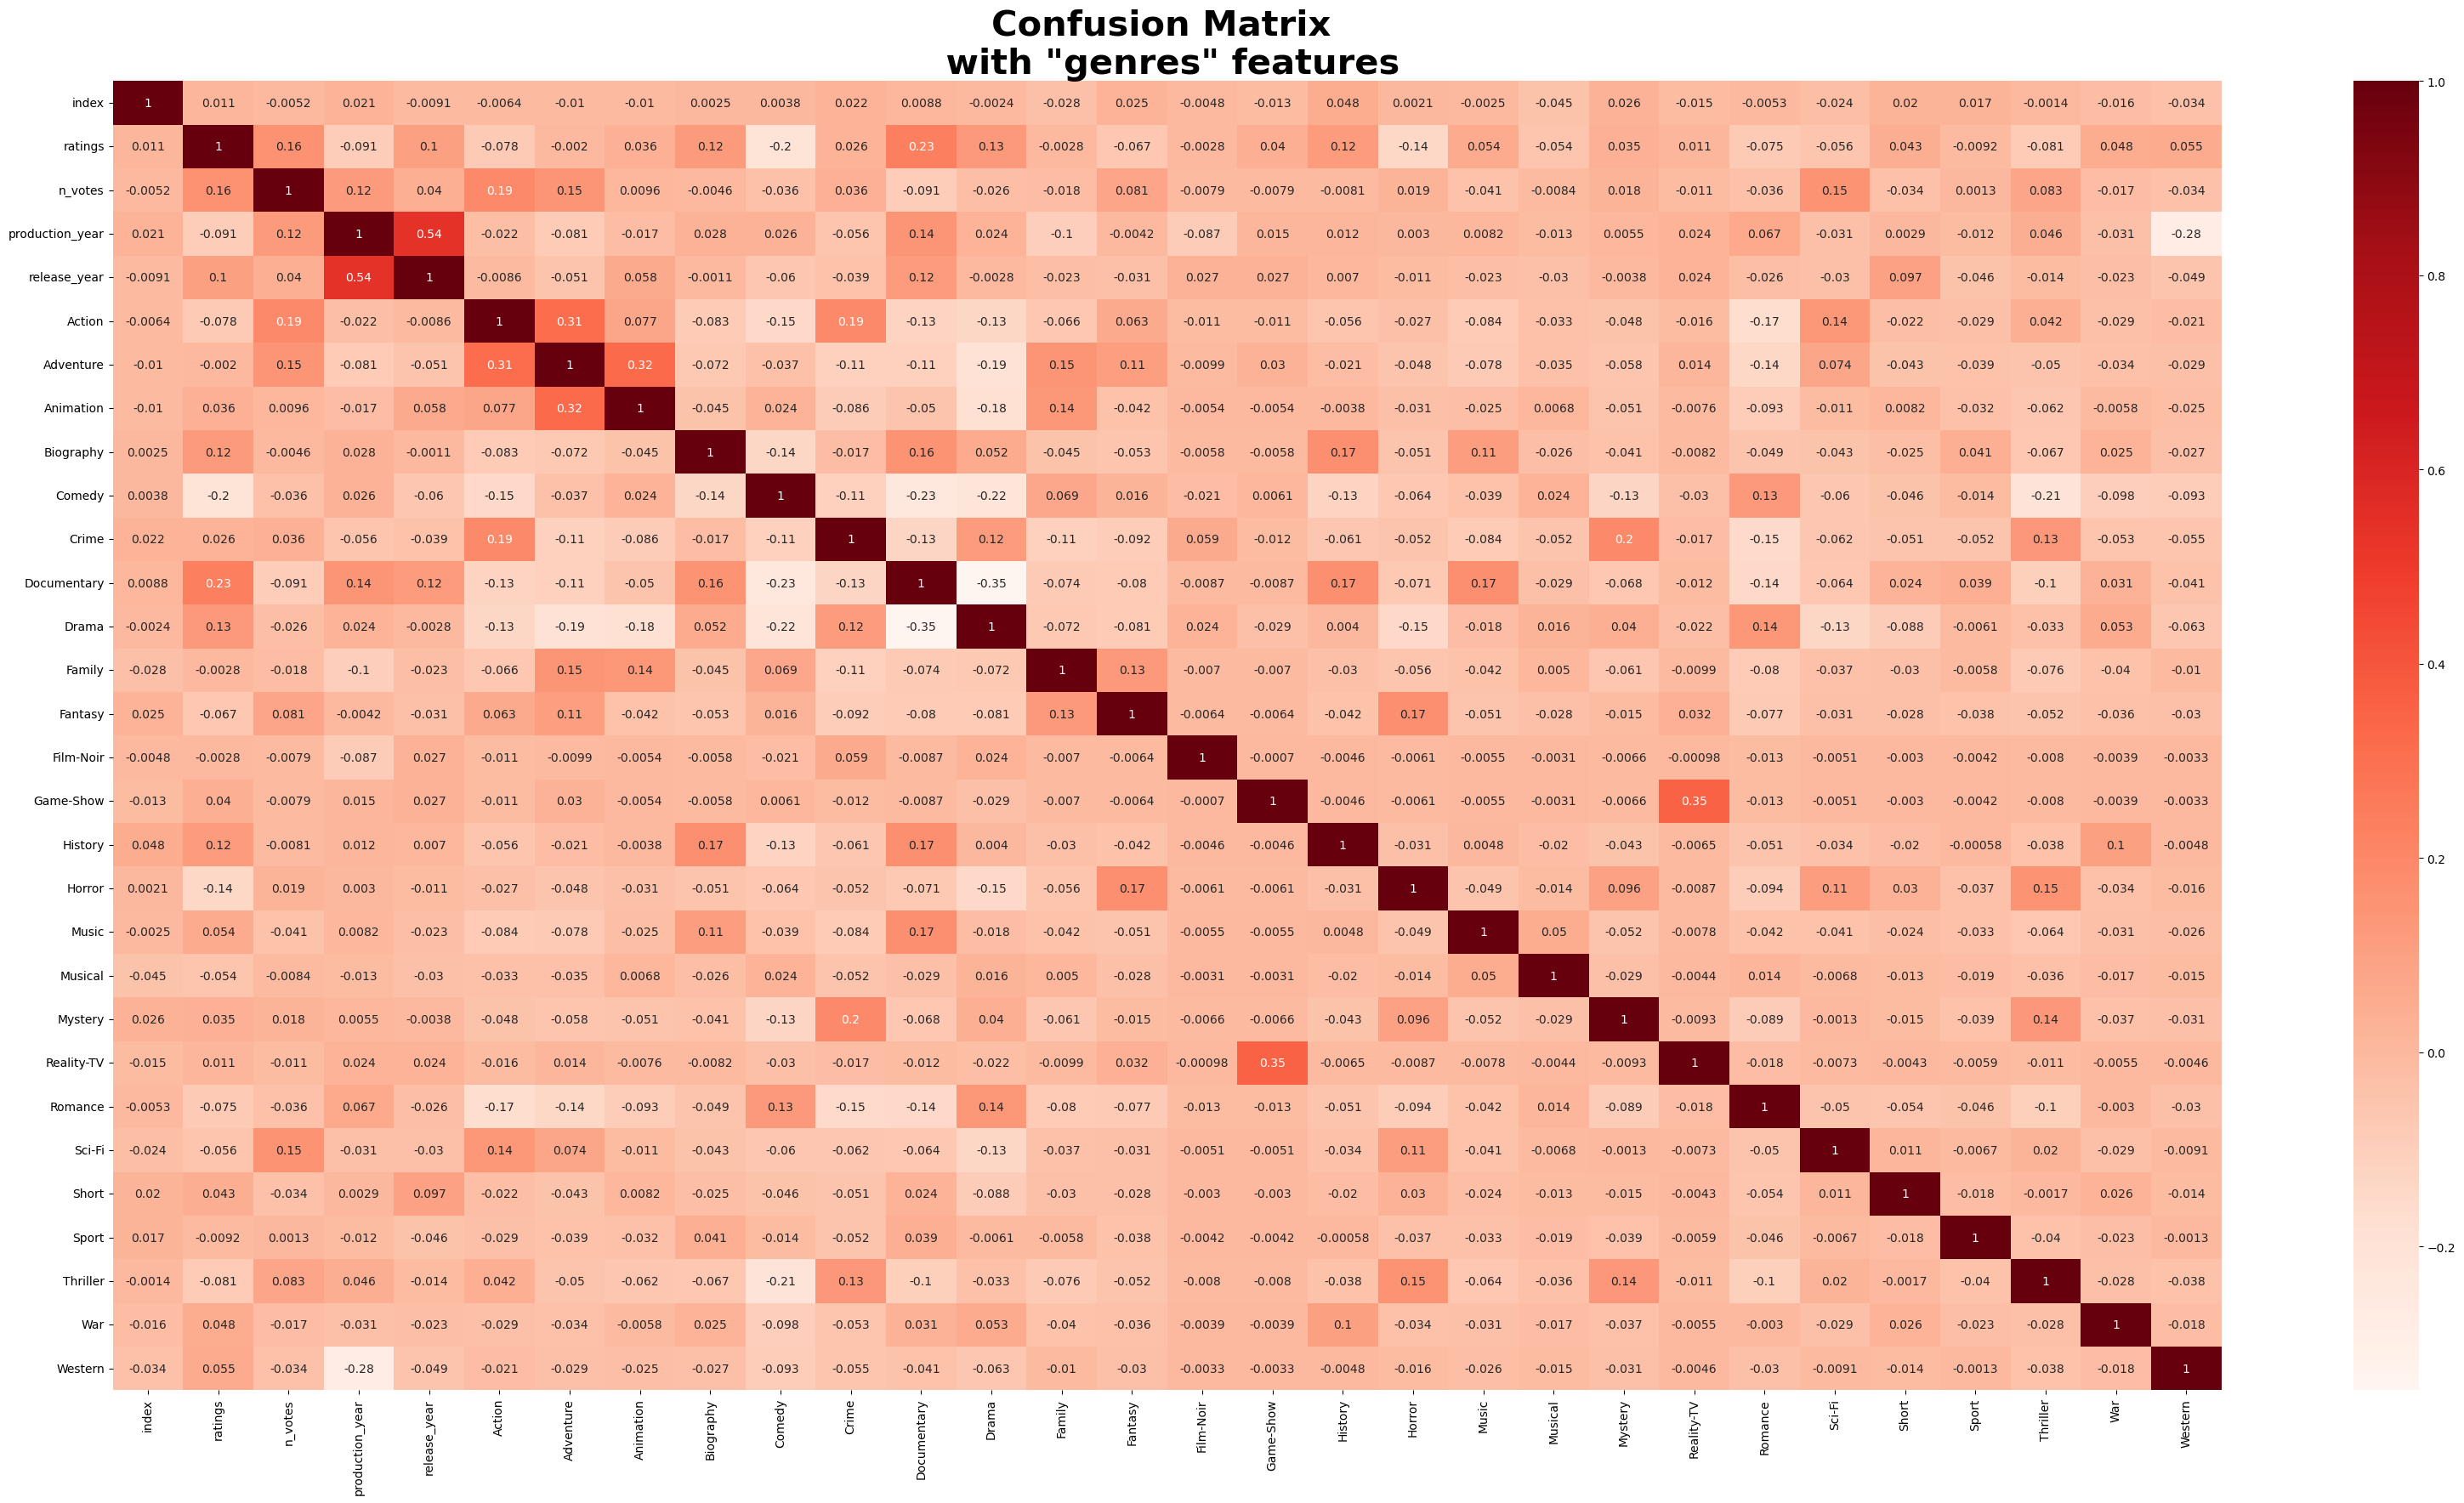

In [10]:
matplotlib.style.use("default")
plt.figure(figsize=(40,20))
corr = df1.drop(columns = ["is_adult"]).corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.title("Confusion Matrix \n with \"genres\" features", fontweight="bold", fontsize = 30)
plt.savefig(os.path.join("./figures/", "correlation_genre.svg"))

In [11]:
visu_data = df1[["ratings", "n_votes", "production_year", "runtime", "release_year"]]
visu_data["revenue"] = Y1.iloc[df1["index"]]["revenue"].values

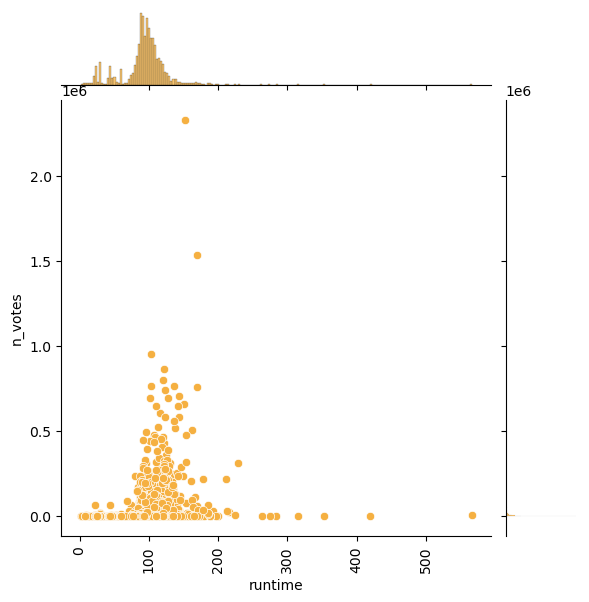

In [12]:
g = sns.jointplot("runtime", "n_votes", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(float(min(visu_data["n_votes"])), float(max(visu_data["n_votes"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)
plt.savefig(os.path.join("./figures/", "nb_votes_vs_runtime.svg"), bbox_inches = 'tight')
plt.show()

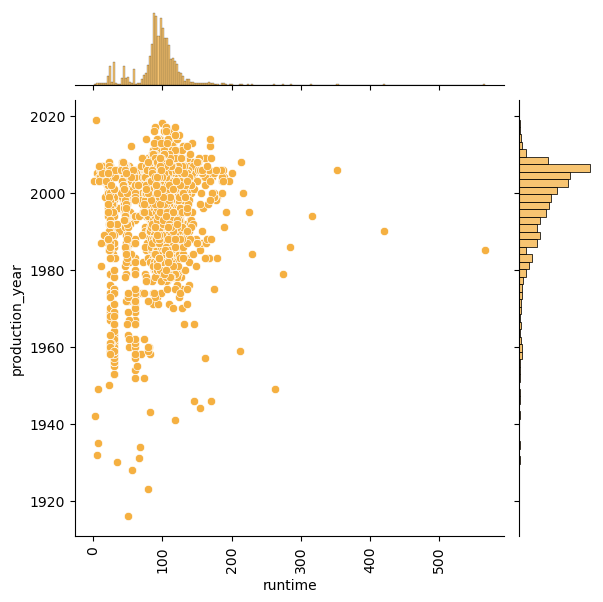

In [13]:
g = sns.jointplot("runtime", "production_year", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["production_year"])), int(max(visu_data["production_year"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)

plt.savefig(os.path.join("./figures/", "prod_year_vs_runtime.svg"), bbox_inches = 'tight')
plt.show()

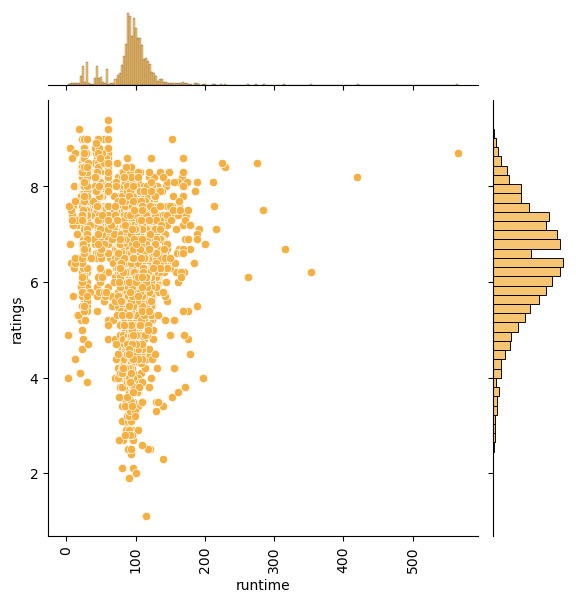

In [14]:
g = sns.jointplot("runtime", "ratings", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["ratings"])), int(max(visu_data["ratings"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)

plt.savefig(os.path.join("./figures/", "ratings_vs_runtime.svg"), bbox_inches = 'tight')
plt.show()

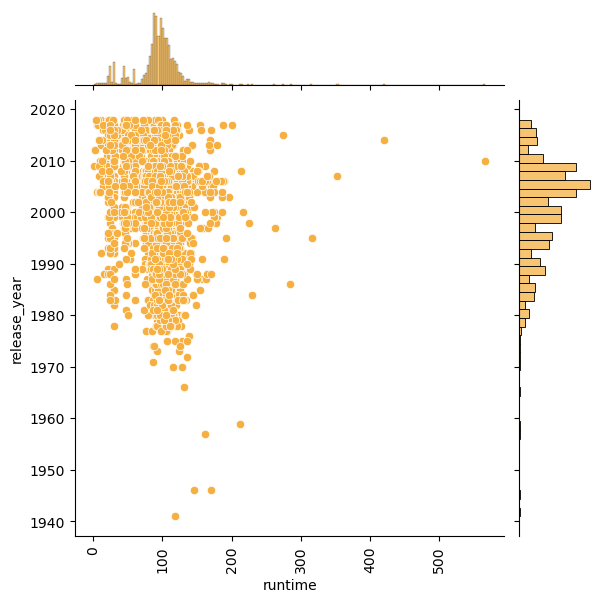

In [15]:
g = sns.jointplot("runtime", "release_year", data=visu_data, color='#F5B041')
#g.ax_joint.set_xticks(np.linspace(int(min(visu_data["release_year"])), int(max(visu_data["release_year"])), 10))
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(90)

plt.savefig(os.path.join("./figures/", "release_year_vs_runtime.svg"), bbox_inches = 'tight')
plt.show()

### Outliers Removal

The columns 0 named ratings dropped 1 elements !
The columns 1 named n_votes dropped 35 elements !
The columns 2 named production_year dropped 50 elements !
The columns 3 named release_year dropped 52 elements !


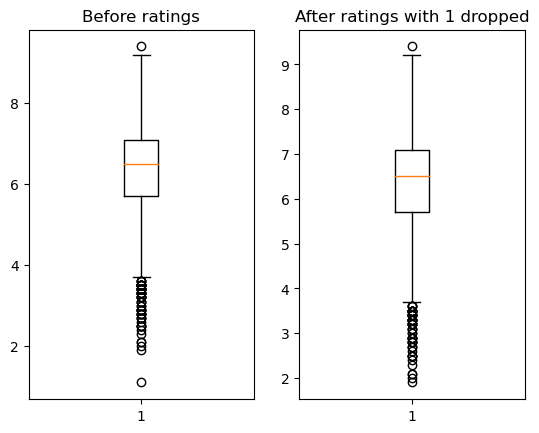

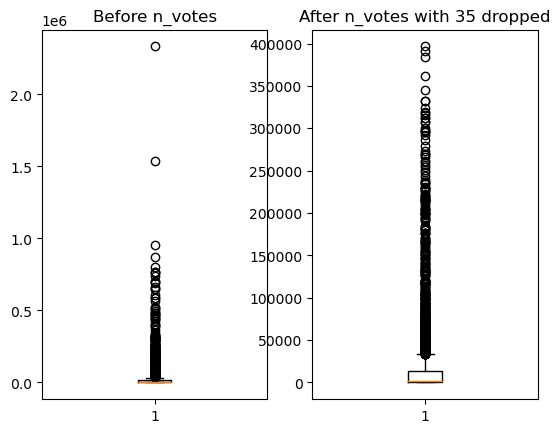

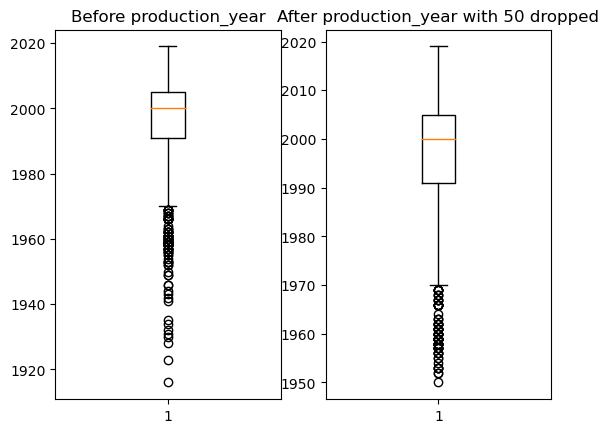

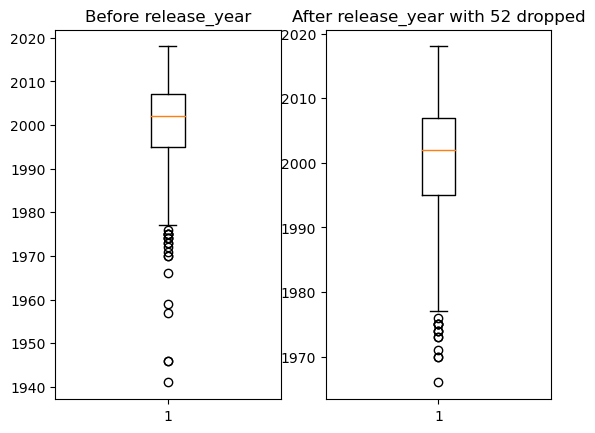

In [16]:
X2 = visu_data.drop(columns=["revenue", "runtime"])
y2 = Y1.copy()

y2.reset_index(inplace=True)
y2 = y2.drop(columns=["index"])

X3 = X2.copy()
y3 = y2.copy()

for i, col in enumerate(X2.columns) :
    
    fig1, (ax1, ax2) = plt.subplots(1,2)
    
    
    nb_init = len(X2[col])
    
    mean = np.mean(X2[col].values)
    std = np.std(X2[col].values)
    
    idx1 = X3[X3[col] > mean + 4*std].index
    idx2 = X3[X3[col] < mean - 4*std].index
    X3.drop(idx1, inplace=True)
    X3.drop(idx2, inplace=True)
    
    y3.drop(idx1, inplace=True)
    y3.drop(idx2, inplace=True)

    nb_final = len(X3[col])
    
    print(f"The columns {i} named {col} dropped {nb_init-nb_final} elements !")

    
    ax1.set_title(f'Before {col}')
    ax1.boxplot(X2[col].values)
    
    ax2.set_title(f'After {col} with {nb_init-nb_final} dropped')
    ax2.boxplot(X3[col].values)

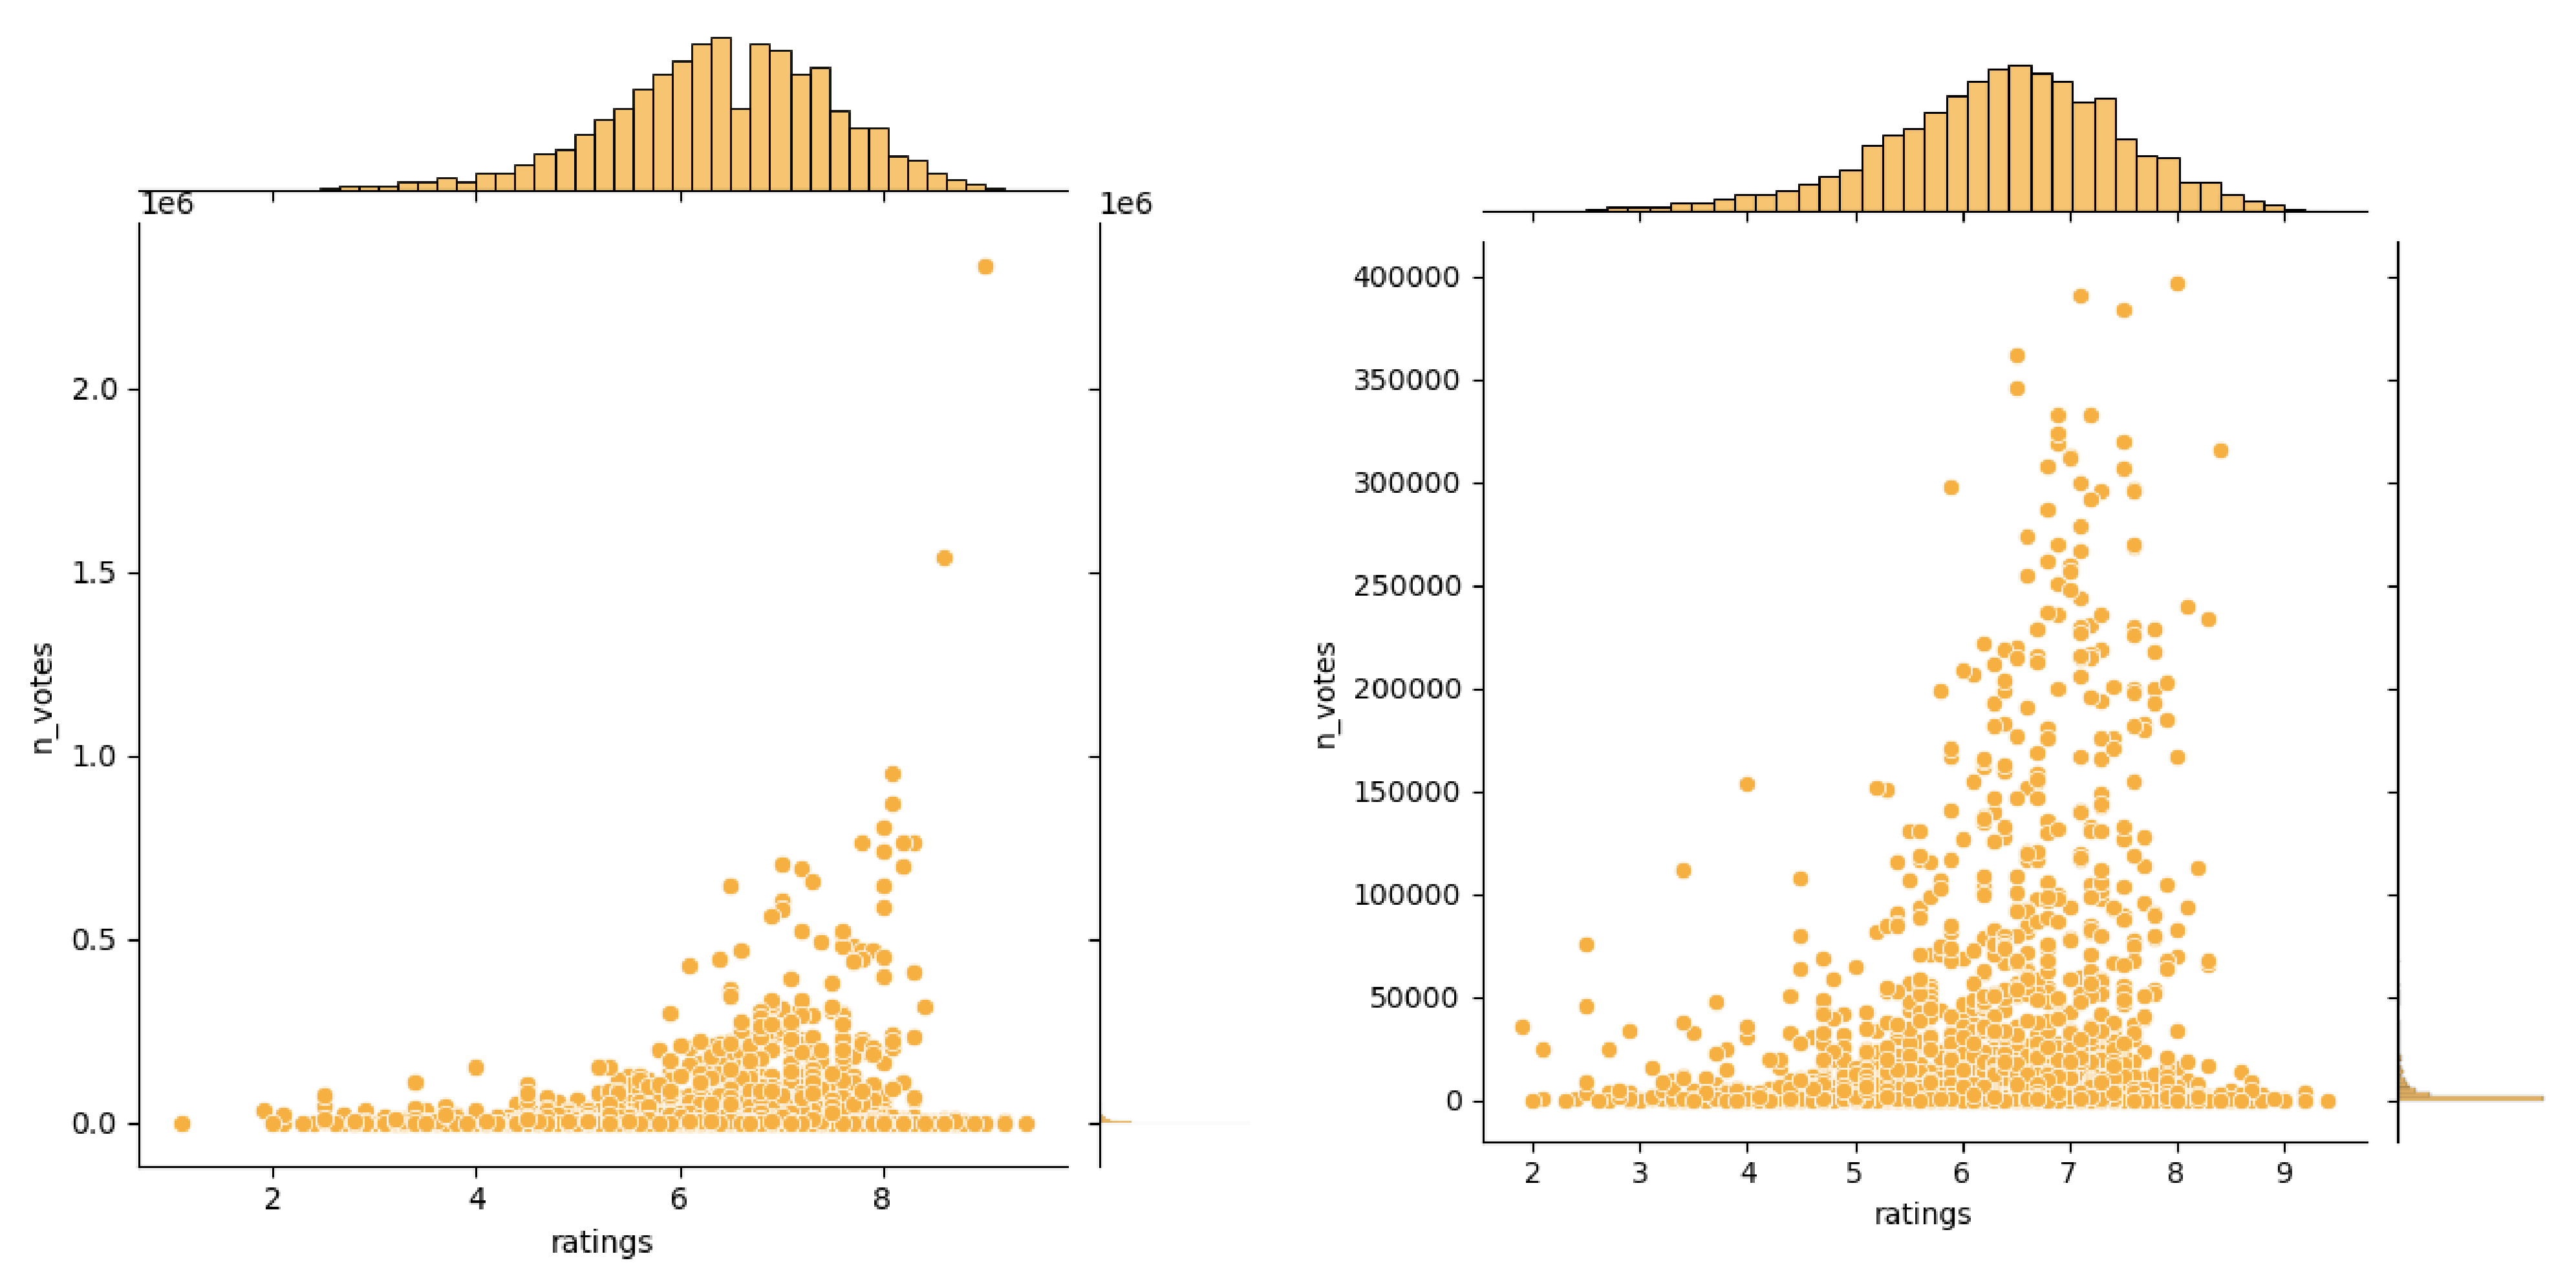

In [17]:
import matplotlib.image as mpimg


g0 = sns.jointplot("ratings", "n_votes", data=visu_data, color='#F5B041')
#plt.title("Before removing outliers", fontweight="bold", fontsize = 30)

g1= sns.jointplot("ratings", "n_votes", data=X3, color='#F5B041')
#plt.title("After removing outliers", fontweight="bold", fontsize = 30)

g0.savefig(os.path.join("./figures/", 'g0.png'))
plt.close(g0.fig)

g1.savefig(os.path.join("./figures/", 'g1.png'))
plt.close(g1.fig)




f, axarr = plt.subplots(1, 2, figsize=(40, 20))

axarr[0].imshow(mpimg.imread(os.path.join("./figures/", 'g0.png')))
axarr[1].imshow(mpimg.imread(os.path.join("./figures/", 'g1.png')))


# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.savefig(os.path.join("./figures/", "before_after_outliers.svg"))
plt.show()

In [18]:
from PIL import Image
import PIL.ImageDraw as ImageDraw  
import imageio
import os


def plot_anim(df, animate=False, svg=False) :
    
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111, projection='3d')
    
    col = df.columns
    z, x, y = df[col[0]], df[col[1]], df[col[2]] 
    
    ax.scatter(x,y,z, c='b', marker='o') 
    
    ax.set_zlabel(col[0])
    ax.set_xlabel(col[1])
    ax.set_ylabel(col[2])
    
    
    if animate :
        nb = 360
        for i in range(nb) :
            ax.view_init(elev=10., azim=i)
            plt.savefig(f"videos/{i}.png")
            
        tmp_frames = []
        for i in range(nb) :
            img = imageio.imread(f"videos/{i}.png")
            tmp_frames.append(Image.fromarray(img))
    
        imageio.mimwrite(os.path.join('./videos/', 'video.gif'), tmp_frames, fps=10)
    
    if svg:
        ax.view_init(elev=30., azim=30)
        plt.savefig(os.path.join('./figures/', "plot.svg"))
    
    plt.show()

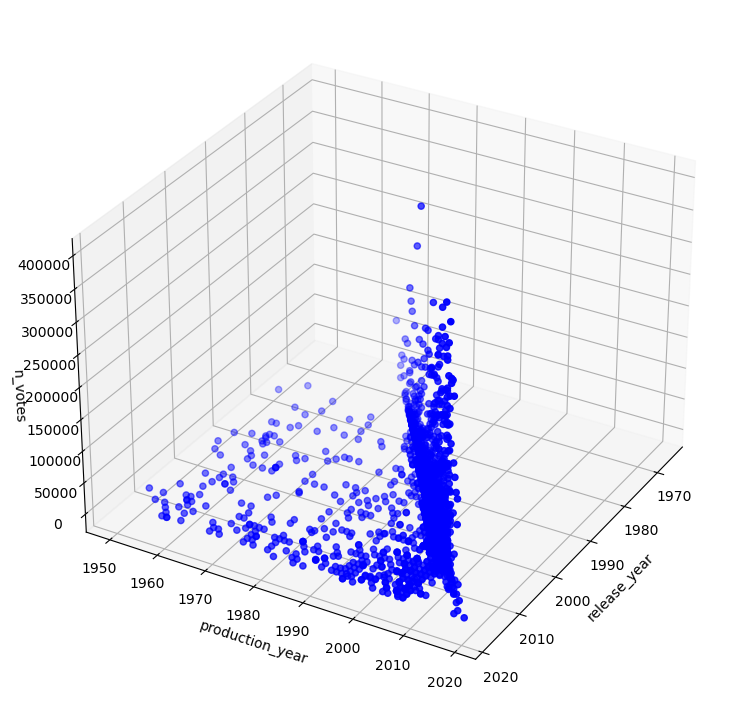

In [19]:
plot_anim(X3[["n_votes", "release_year", "production_year"]], animate=False, svg=True)

## 3.0 Setup for prediction with K-fold for any model

In [89]:
def pred_with_model(model, X_train, y_train, X_test, y_test) :
    


    if isinstance(model, keras.engine.sequential.Sequential) :
        history = model.fit(X_train, y_train, epochs=10, 
                             batch_size=32, 
                             verbose=0,
                             shuffle=False)
        
        y_preds = y_test.copy()
        for i in range(len(y_preds)) :
            x = tf.convert_to_tensor(X_test.iloc[i].values.reshape(1, X_test.shape[-1]), dtype=tf.int64) 
            y_preds.iloc[i] = model.predict(x)
        

        
    else : 
        model.fit(X_train, y_train)
        history = None
        
        y_preds = y_test.copy()
        for i in range(len(y_preds)) :
            x = X_test.iloc[i].values.reshape(1, X_test.shape[-1])
            y_preds.iloc[i] = model.predict(x)
    
    
        
    return y_preds, history

In [80]:
def compute_rmse(predict, target):
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

### Predictions using K-FOLD

In [90]:
from sklearn.model_selection import KFold


def kfold_with_model(model, X, y, nb_split = 5) :
    """
    X : Training set
    y : Training set target
    
    """
    kf = KFold(n_splits=nb_split)
    RMSE = list()

    idx = 1
    print("begginning of Kfold")
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        

        y_preds, history = pred_with_model(model, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    
        
        print(y_preds.shape)
        
        actual_rmse = compute_rmse(np.exp(y_preds), np.exp(y_test_fold))
        RMSE.append(actual_rmse)
        
        print(f"The RMSE at iteration {idx} of K-Fold is {actual_rmse}")
        
        
        if isinstance(model, keras.engine.sequential.Sequential) :
            if idx == 1 :
                weights = model.get_weights()
            else :
                model.set_weights(weights)
        
        idx+=1

    print("Mean RMSE : ", np.mean(RMSE), "Std RMSE :", np.std(RMSE))
    
    return y_preds

In [91]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def scaling_split_data(X, y, size = 0.2, y_scaling = True) :

    # Dividing into training and validation sets
    X_train, X_valid = train_test_split(X, test_size=size, shuffle=False)
    y_train, y_valid = train_test_split(y, test_size=size, shuffle=False)

    # Scaling the datasets. Be careful, scaler is only fit on train set and then applied on test set !
    y_train_scaled = y_train.copy()

    scaler = MinMaxScaler()   # Scaling features
    scaler_y = MinMaxScaler(feature_range=(0, 1)) # Scaling target

    X_train_scaled = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns) # Scaling Training data
    if y_scaling :
        y_train_scaled["revenue"] = scaler_y.fit_transform(y_train["revenue"].to_numpy().reshape(len(y_train["revenue"]),1)) # Scale target
    
    return X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y

## 3.1 First prediction using Linear Regression

In [120]:
X = df1.copy()
y = Y1.reset_index()
y = y.set_index("index")
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y, y_scaling = False)

In [107]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
y_p = kfold_with_model(model, X_train_scaled, y_train_scaled)

begginning of Kfold
(461, 1)
The RMSE at iteration 1 of K-Fold is 76661464.23295914
(461, 1)
The RMSE at iteration 2 of K-Fold is 81504830.15076347
(460, 1)
The RMSE at iteration 3 of K-Fold is 74498207.66055954
(460, 1)
The RMSE at iteration 4 of K-Fold is 78363706.83888653
(460, 1)
The RMSE at iteration 5 of K-Fold is 61750840.44617707
Mean RMSE :  74555809.86586915 Std RMSE : 6799901.505815191


## 3.2 First Prediction using KNN

In [108]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
y_p = kfold_with_model(model, X_train_scaled, y_train_scaled)

begginning of Kfold
(461, 1)
The RMSE at iteration 1 of K-Fold is 76159032.49773262
(461, 1)
The RMSE at iteration 2 of K-Fold is 81074696.25985616
(460, 1)
The RMSE at iteration 3 of K-Fold is 73999260.1077504
(460, 1)
The RMSE at iteration 4 of K-Fold is 78021430.7087935
(460, 1)
The RMSE at iteration 5 of K-Fold is 61508582.09345149
Mean RMSE :  74152600.33351685 Std RMSE : 6735038.84169423


## 3.3 First Prediction using RandomForest

In [109]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
y_p = kfold_with_model(model, X_train_scaled, y_train_scaled)


begginning of Kfold
(461, 1)
The RMSE at iteration 1 of K-Fold is 76543442.40732548
(461, 1)
The RMSE at iteration 2 of K-Fold is 81464894.07383509
(460, 1)
The RMSE at iteration 3 of K-Fold is 74224485.15768705
(460, 1)
The RMSE at iteration 4 of K-Fold is 78247545.32688542
(460, 1)
The RMSE at iteration 5 of K-Fold is 61686076.61533867
Mean RMSE :  74433288.71621434 Std RMSE : 6796760.864827357


In [110]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
y_p = kfold_with_model(model, X_train_scaled, y_train_scaled)


begginning of Kfold
(461, 1)
The RMSE at iteration 1 of K-Fold is 101737398.33457427
(461, 1)
The RMSE at iteration 2 of K-Fold is 91845945.44668931
(460, 1)
The RMSE at iteration 3 of K-Fold is 105906637.51390228
(460, 1)
The RMSE at iteration 4 of K-Fold is 97534801.12168352
(460, 1)
The RMSE at iteration 5 of K-Fold is 109647599.03813057
Mean RMSE :  101334476.290996 Std RMSE : 6239307.064186286


## 3.4 First Prediction using Neural Network

In [118]:
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D

def NN(output_shape = 1, input_shape = None, lr=1e-2) :

    model = Sequential()
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(output_shape, activation="sigmoid"))
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  metrics = tf.keras.metrics.RootMeanSquaredError(name='RMSE'))
    
    return model

In [121]:
model = NN()
y_preds_NN = kfold_with_model(model, X_train_scaled, y_train_scaled)


begginning of Kfold
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 9ms/step
(461, 1)
The RMSE at iteration 1 of K-Fold is 77004892.84069136
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
(461, 1)
The RMSE at iteration 2 of K-Fold is 81805547.10607925
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
(460, 1)
The RMSE at iteration 3 of K-Fold is 74810115.62169068
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
(460, 1)
The RMSE at iteration 4 of K-Fold is 78641289.25800775
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
(460, 1)
The RMSE at iteration 5 of K-Fold is 62127756.95342433
Mean RMSE :  74877920.35597868 Std RMSE : 6771266.264237754


## 4. GridSearch Performing

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def perform_grid_search(model_, hyper_params_grid, score_function, X_train, Y_train):
    
    scorer = make_scorer(score_function)
    grid = GridSearchCV(estimator=model_, param_grid=hyper_params_grid, scoring = scorer)
    grid.fit(X_train, Y_train)
    
    return grid

In [123]:
from sklearn.feature_selection import SequentialFeatureSelector

def pred_with_decision_tree(X_train, y_train, X_test):
    
    decision_tree = DecisionTreeRegressor()
    params = {'splitter' : ("best", "random"), 'min_samples_split' : [0.5,2,5,10,20] ,'min_impurity_decrease': [0.0,0.5,1.0] ,'criterion' : ("friedman_mse", "squared_error","absolute_error", "poisson"), 'ccp_alpha' : [0.0,0.1,0.5, 0.75],'max_features' : ('auto','sqrt', 'log2'), 'random_state' : [None,0,1,3]}
    grid_search = perform_grid_search(decision_tree, params, compute_rmse, X_train, y_train)
    preds = grid_search.predict(X_test)
    
    return preds, grid_search.best_params_

def pred_with_knn(X_train, y_train, X_test):
    
    knn_sfs  = KNeighborsRegressor()
    feature  = SequentialFeatureSelector(knn_sfs, n_features_to_select=3)
    X_train2 = feature.fit_transform(X_train, y_train)
    X_test2  =  feature.transform(X_test)
    
    knn = KNeighborsRegressor()
    params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12]}
    
    grid_search = perform_grid_search(knn, params, compute_rmse, X_train2, y_train)
    preds = grid_search.predict(X_test2)
    
    return preds, grid_search.best_params_

def pred_with_random_forest(X_train, y_train, X_test):
    
    RandomForest_sfs  = RandomForestRegressor()
    feature  = SequentialFeatureSelector(RandomForest_sfs, n_features_to_select=3)
    X_train2 = feature.fit_transform(X_train, y_train)
    X_test2  = feature.transform(X_test)
    
    RandomForest = RandomForestRegressor()
    params = {'criterion' : ("squared_error","absolute_error", "poisson"), 'min_samples_split' : [2,3,4,5,6], 'max_features' : ("auto", "sqrt", "log2")}
    grid_search = perform_grid_search(RandomForest, params, compute_rmse, X_train2, y_train)
    preds = grid_search.predict(X_test2)
    
    return preds, grid_search.best_params_

def pred_with_NN(X_train, y_train, X_test, y_test):
    
    model = NN()
    
    return pred_with_model(model, X_train, y_train, X_test, y_test)

In [129]:
from sklearn.metrics import r2_score

X = df1.copy()
y = Y1.reset_index()
y = y.set_index("index")
X.drop(columns=["index"], inplace=True)

X_train_scaled, y_train_scaled, X_valid, y_valid, scaler, scaler_y = scaling_split_data(X, y)


kf = KFold(shuffle = True)

RMSE_decision_tree = list()
RMSE_knn           = list()
RMSE_random_forest = list()
RMSE_MLP           = list()

R2_decision_tree   = list()
R2_knn             = list()
R2_random_forest   = list()
R2_MLP             = list()

old_r2_decision_tree = -np.inf
old_r2_knn           = -np.inf
old_r2_random_forest = -np.inf

for train_index, test_index in kf.split(X_train_scaled):

    X_train, X_test = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train, y_test = y_train_scaled.iloc[train_index], y_train_scaled.iloc[test_index]
        
    #Predictions
    y_pred_decision_tree, best_param_decision_tree = pred_with_decision_tree(X_train, y_train, X_test)
    y_pred_knn,           best_param_knn           = pred_with_knn(X_train, y_train, X_test)
    y_pred_random_forest, best_param_random_forest = pred_with_random_forest(X_train, y_train, X_test)
    y_pred_MLP,           history                  = pred_with_NN(X_train, y_train, X_test, y_test)
    
    #Compute RMSE
    RMSE_decision_tree.append(compute_rmse(y_pred_decision_tree, y_test.to_numpy()))
    RMSE_knn.append(          compute_rmse(y_pred_knn,           y_test.to_numpy()))
    RMSE_random_forest.append(compute_rmse(y_pred_random_forest, y_test.to_numpy()))
    RMSE_MLP.append(          compute_rmse(y_pred_MLP,           y_test.to_numpy()))

    
    #Compute regression scores
    r2_decision_tree = r2_score(y_test.to_numpy(), y_pred_decision_tree)
    r2_knn           = r2_score(y_test.to_numpy(), y_pred_knn)
    r2_random_forest = r2_score(y_test.to_numpy(), y_pred_random_forest)
    r2_MLP           = r2_score(y_test.to_numpy(), y_pred_MLP)
    
    #Store the best parameters
    if(r2_decision_tree > old_r2_decision_tree) :
        param_decision_tree = best_param_decision_tree
        old_r2_decision_tree = r2_decision_tree
        
    if(r2_knn > old_r2_knn) :
        param_knn = best_param_knn
        old_r2_knn = r2_knn
        
    if(r2_random_forest > old_r2_random_forest) :
        param_random_forest = best_param_random_forest
        old_r2_random_forest = r2_random_forest
        
    R2_decision_tree.append(r2_decision_tree)
    R2_knn.append(          r2_knn)
    R2_random_forest.append(r2_random_forest)
    R2_MLP.append(          r2_MLP)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


In [132]:
y_test

,revenue
index,
0,0.844237
26,0.425929
27,0.856733
28,0.829936
29,0.505913
...,...
2260,0.795957
2261,0.873417
2275,0.352390


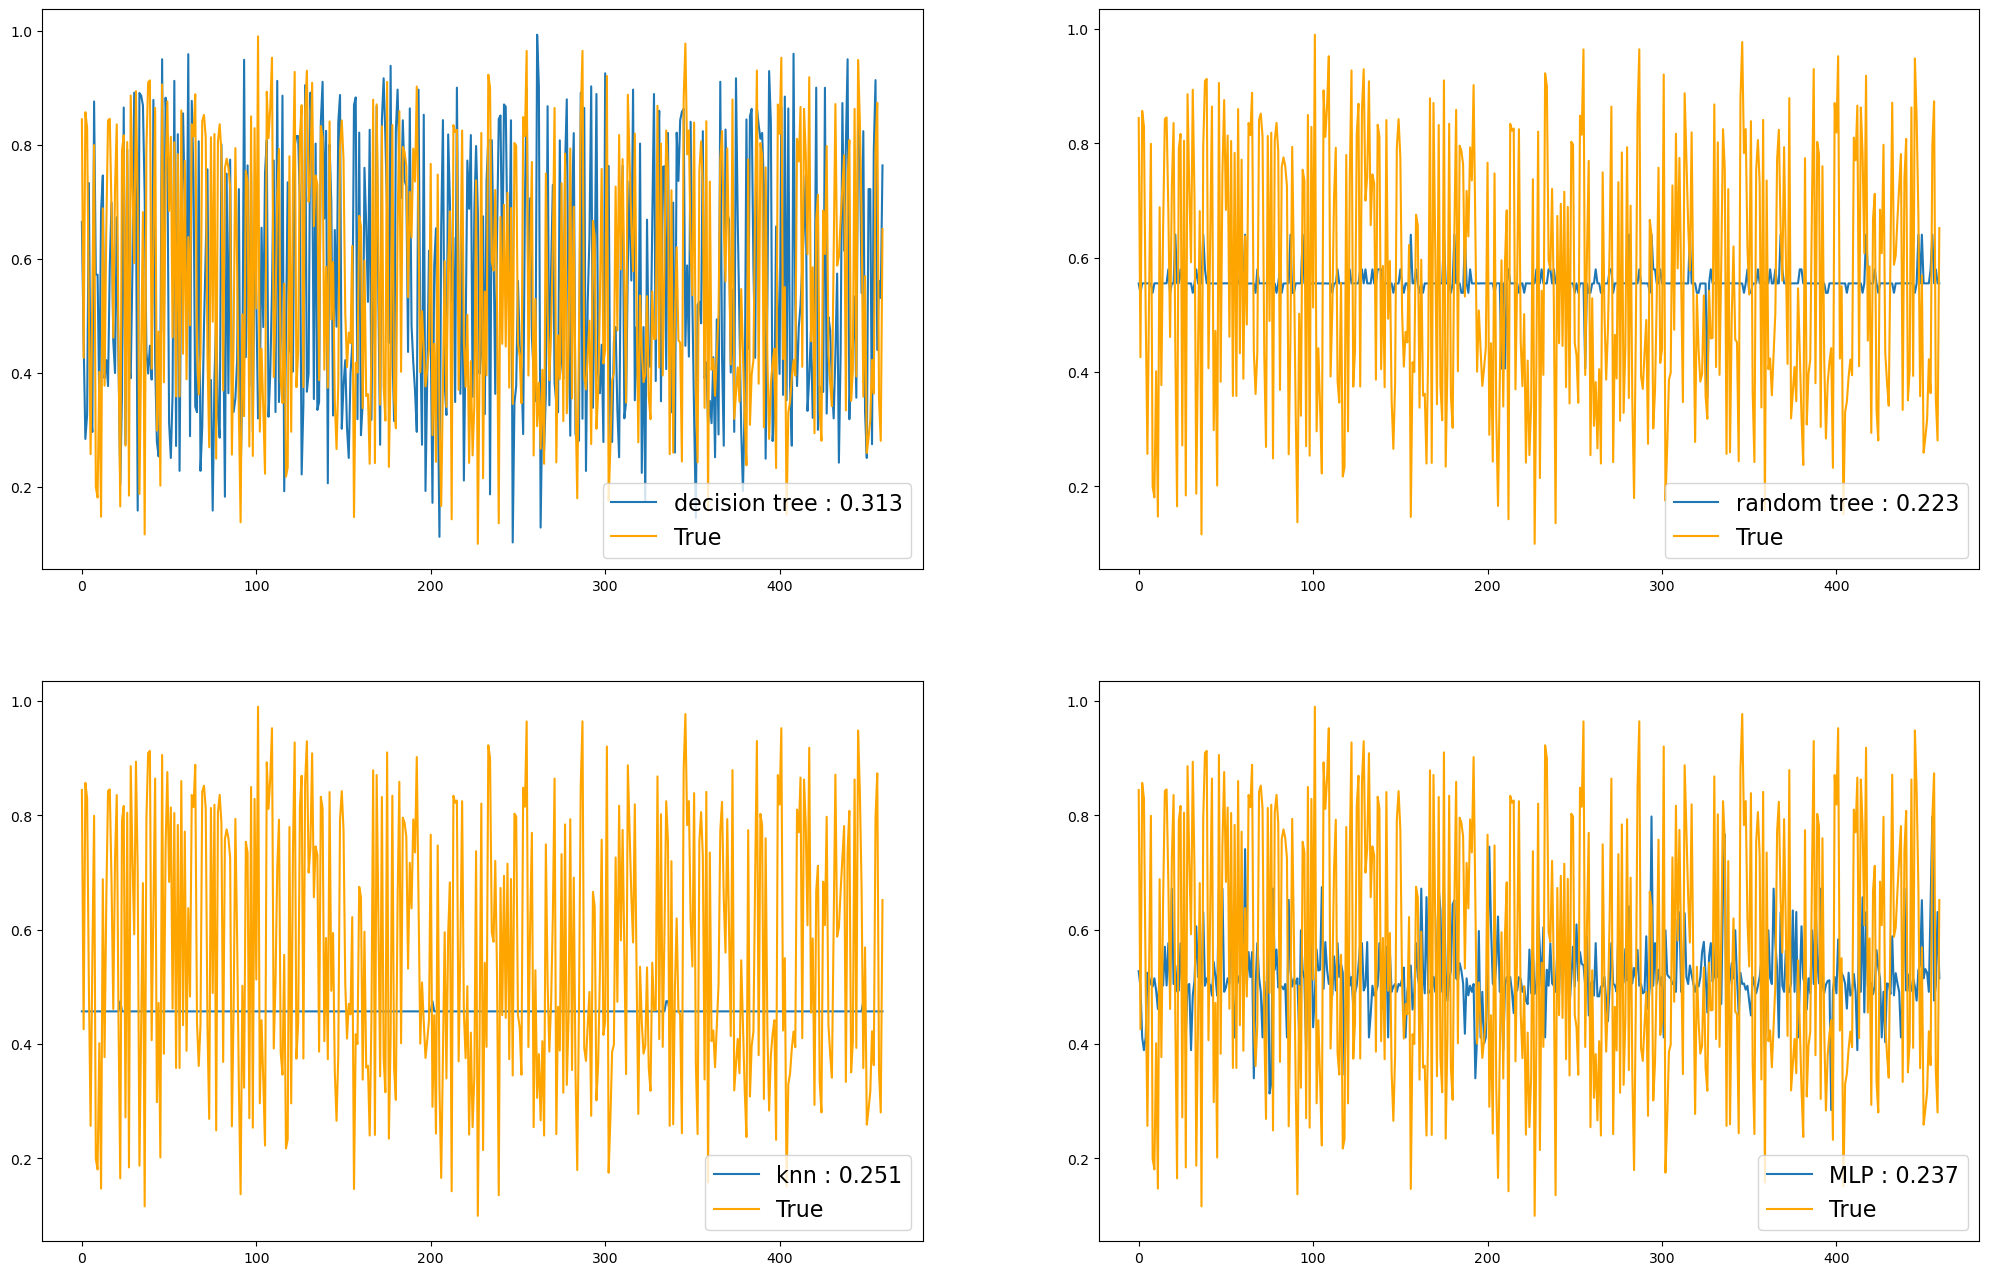

In [130]:
x = np.arange(len(y_test))

fig, ax = plt.subplots(2,2, figsize = (25,16))

# Plot the different model predictions and the real value
ax[0,0].plot(x, y_pred_decision_tree, label = f"decision tree : {np.mean(RMSE_decision_tree):.3f}")
ax[0,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,0].plot(x, y_pred_knn, label = f"knn : {np.mean(RMSE_knn):.3f}")
ax[1,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[0,1].plot(x, y_pred_random_forest, label = f"random tree : {np.mean(RMSE_random_forest):.3f}")
ax[0,1].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,1].plot(x, y_pred_MLP, label = f"MLP : {np.mean(RMSE_MLP):.3f}")
ax[1,1].plot(x, y_test, 'k-', label="True", color="orange")

ax[0,0].legend(fontsize=16)
ax[1,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
ax[1,1].legend(fontsize=16)
plt.savefig(os.path.join("./figures/", "grid_search.svg"))
plt.show()

In [126]:
print("decision Tree: ",best_param_decision_tree, "\n")
print("KNN : ", best_param_knn, "\n")
print("Random Forest : ",best_param_random_forest)

decision Tree:  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'random_state': 3, 'splitter': 'random'} 

KNN :  {'n_neighbors': 2} 

Random Forest :  {'criterion': 'poisson', 'max_features': 'auto', 'min_samples_split': 6}


In [127]:
print(np.mean(R2_decision_tree))
print(np.mean(R2_knn))
print(np.mean(R2_random_forest))
print(np.mean(R2_MLP))

-1.1189465825329172
-0.28426227880542315
-0.011630780026693755
-0.13253762909342184


In [128]:
print(np.mean(RMSE_decision_tree))
print(np.mean(RMSE_knn))
print(np.mean(RMSE_random_forest))
print(np.mean(RMSE_MLP))

0.32353047318519945
0.24982070436424592
0.22355248903819205
0.23643102951303246


# 5. Dataset Augmentation

In [ ]:
data = pd.read_csv("movies.csv")
data.dropna(inplace=True)
data = data[["year", "released", "score", "votes", "gross", "runtime"]]

for i in range(len(data)) :
    try :
        data["released"].iloc[i] = float(data["released"].iloc[i].split("(")[0].split(",")[-1].replace(" ", ""))
    except :
        data["released"].iloc[i] = np.nan

data.rename(columns = {'year':'production_year', 'released' : 'release_year', 'votes':'n_votes', 'gross' : 'revenue', 'score' : 'ratings'}, inplace = True)
data.dropna(inplace=True)
data

In [ ]:
augm_y = data["revenue"].to_frame()
data.drop(columns="revenue", inplace=True)
new_X_train = pd.DataFrame(data=scaler.inverse_transform(X_train_scaled), columns=X_train_scaled.columns)
new_y_train = pd.DataFrame(data=scaler_y.inverse_transform(y_train_scaled), columns=y_train_scaled.columns)


df2 = pd.concat([data, new_X_train[["ratings", "n_votes", "production_year", "runtime", "release_year"]]])
Y_f = pd.concat([augm_y, new_y_train])

In [ ]:
from sklearn.metrics import r2_score

X_train_scaled_aug, y_train_scaled_aug, X_valid_aug, y_valid_aug, scaler_aug, scaler_y_aug = scaling_split_data(df2, Y_f)


kf = KFold(shuffle = True)

RMSE_decision_tree_aug = list()
RMSE_knn_aug           = list()
RMSE_random_forest_aug = list()
RMSE_MLP_aug           = list()

R2_decision_tree_aug   = list()
R2_knn_aug             = list()
R2_random_forest_aug   = list()
R2_MLP_aug             = list()

old_r2_decision_tree_aug = -np.inf
old_r2_knn_aug           = -np.inf
old_r2_random_forest_aug = -np.inf

for train_index, test_index in kf.split(X_train_scaled_aug):

    X_train, X_test = X_train_scaled_aug.iloc[train_index], X_train_scaled_aug.iloc[test_index]
    y_train, y_test = y_train_scaled_aug.iloc[train_index], y_train_scaled_aug.iloc[test_index]
        
    #Predictions
    y_pred_decision_tree_aug, best_param_decision_tree_aug = pred_with_decision_tree(X_train, y_train, X_test)
    y_pred_knn_aug,           best_param_knn_aug           = pred_with_knn(X_train, y_train, X_test)
    y_pred_random_forest_aug, best_param_random_forest_aug = pred_with_random_forest(X_train, y_train, X_test)
    y_pred_MLP_aug,           history_aug                  = pred_with_NN(X_train, y_train, X_test, y_test)
    
    #Compute RMSE
    RMSE_decision_tree_aug.append(compute_rmse(y_pred_decision_tree_aug, y_test.to_numpy()))
    RMSE_knn_aug.append(          compute_rmse(y_pred_knn_aug,           y_test.to_numpy()))
    RMSE_random_forest_aug.append(compute_rmse(y_pred_random_forest_aug, y_test.to_numpy()))
    RMSE_MLP_aug.append(          compute_rmse(y_pred_MLP_aug,           y_test.to_numpy()))

    
    #Compute regression scores
    r2_decision_tree_aug = r2_score(y_test.to_numpy(), y_pred_decision_tree_aug)
    r2_knn_aug           = r2_score(y_test.to_numpy(), y_pred_knn_aug)
    r2_random_forest_aug = r2_score(y_test.to_numpy(), y_pred_random_forest_aug)
    r2_MLP_aug           = r2_score(y_test.to_numpy(), y_pred_MLP_aug)
    
    #Store the best parameters
    if(r2_decision_tree_aug > old_r2_decision_tree_aug) :
        param_decision_tree_aug = best_param_decision_tree_aug
        old_r2_decision_tree_aug = r2_decision_tree_aug
        
    if(r2_knn_aug > old_r2_knn_aug) :
        param_knn_aug = best_param_knn_aug
        old_r2_knn_aug = r2_knn_aug
        
    if(r2_random_forest_aug > old_r2_random_forest_aug) :
        param_random_forest_aug = best_param_random_forest_aug
        old_r2_random_forest_aug = r2_random_forest_aug
        
    R2_decision_tree_aug.append(r2_decision_tree_aug)
    R2_knn_aug.append(          r2_knn_aug)
    R2_random_forest_aug.append(r2_random_forest_aug)
    R2_MLP_aug.append(          r2_MLP_aug)

In [ ]:
print(np.mean(R2_decision_tree_aug))
print(np.mean(R2_knn_aug))
print(np.mean(R2_random_forest_aug))
print(np.mean(R2_MLP_aug))

In [ ]:
print(np.mean(RMSE_decision_tree_aug))
print(np.mean(RMSE_knn_aug))
print(np.mean(RMSE_random_forest_aug))
print(np.mean(RMSE_MLP_aug))

In [ ]:
x = np.arange(len(y_test))

fig, ax = plt.subplots(2,2, figsize = (30,16))

# Plot the different model predictions and the real value
ax[0,0].plot(x, y_pred_decision_tree_aug, label = f"decision tree : {np.mean(RMSE_decision_tree_aug):.3f}")
ax[0,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,0].plot(x, y_pred_knn_aug, label = f"knn : {np.mean(RMSE_knn_aug):.3f}")
ax[1,0].plot(x, y_test, 'k-', label="True", color="orange")
ax[0,1].plot(x, y_pred_random_forest_aug, label = f"random tree : {np.mean(RMSE_random_forest_aug):.3f}")
ax[0,1].plot(x, y_test, 'k-', label="True", color="orange")
ax[1,1].plot(x, y_pred_MLP_aug, label = f"MLP : {np.mean(RMSE_MLP_aug):.3f}")
ax[1,1].plot(x, y_test, 'k-', label="True", color="orange")

ax[0,0].legend(fontsize=16)
ax[1,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
ax[1,1].legend(fontsize=16)
plt.savefig(os.path.join("./figures/", "grid_search_aug.svg"))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
example_data1 = [RMSE_random_forest, RMSE_decision_tree, RMSE_knn]
example_data2 = [RMSE_random_forest_aug, RMSE_decision_tree_aug, RMSE_knn_aug]

fig, ax = plt.subplots()
bp1 = box_plot(example_data1, 'red', 'lightcoral')
bp2 = box_plot(example_data2, 'blue', 'lightskyblue')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original Data', 'Augmented Data'])
#ax.set_ylim(0, 10)
plt.title("Boxplot of the RMSE for the different model with both dataset")
plt.xticks([1, 2, 3], ["Random Forest", "Decision Tree", "KNN"])
plt.savefig(os.path.join("./figures/", "Boxplot_RMSE.svg"))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp
    
example_data1 = [R2_random_forest, R2_decision_tree, R2_knn]
example_data2 = [R2_random_forest_aug, R2_decision_tree_aug, R2_knn_aug]

fig, ax = plt.subplots()
bp1 = box_plot(example_data1, 'red', 'lightcoral')
bp2 = box_plot(example_data2, 'blue', 'lightskyblue')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Original Data', 'Augmented Data'])
#ax.set_ylim(0, 10)
plt.title("Boxplot of the R2-score for the different model with both dataset")
plt.xticks([1, 2, 3], ["Random Forest", "Decision Tree", "KNN"])
plt.savefig(os.path.join("./figures/", "Boxplot_R2.svg"))
plt.show()

## Fair comparison on same valid set

### Original dataset

In [ ]:
X_valid_base = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)
y_valid_base = pd.DataFrame(data=scaler_y.transform(y_valid), columns=y_valid.columns)

dtr = DecisionTreeRegressor(ccp_alpha= 0.0, criterion="poisson", max_features="log2", min_impurity_decrease=0.0, min_samples_split= 2, random_state=1, splitter="random")
dtr.fit(X_train_scaled, y_train_scaled)
dtr_preds = dtr.predict(X_valid_base)
RMSE_dtr, R2_dtr = compute_rmse(dtr_preds, y_valid_base.to_numpy()), r2_score(y_valid_base.to_numpy(), dtr_preds)

knn_val = KNeighborsRegressor(n_neighbors=2)
knn_val.fit(X_train_scaled, y_train_scaled)
knn_preds = knn_val.predict(X_valid_base)
RMSE_knn, R2_knn = compute_rmse(knn_preds, y_valid_base.to_numpy()), r2_score(y_valid_base.to_numpy(), knn_preds)

rf = RandomForestRegressor(criterion = 'poisson', max_features = 'sqrt', min_samples_split = 6)
rf.fit(X_train_scaled, y_train_scaled)
rf_preds = rf.predict(X_valid_base)
RMSE_rf, R2_rf = compute_rmse(rf_preds, y_valid_base.to_numpy()), r2_score(y_valid_base.to_numpy(), rf_preds)


print(RMSE_dtr, R2_dtr)
print(RMSE_knn, R2_knn)
print(RMSE_rf, R2_rf)



### Augmented dataset

In [ ]:
X_valid_augmented = X_valid[['production_year', 'release_year', 'ratings', 'n_votes', 'runtime']]

X_valid_augmented = pd.DataFrame(data=scaler_aug.transform(X_valid_augmented), columns=X_valid_augmented.columns)
y_valid_augmented = pd.DataFrame(data=scaler_y_aug.transform(y_valid), columns=y_valid.columns)

dtr = DecisionTreeRegressor(ccp_alpha= 0.0, criterion="poisson", max_features="log2", min_impurity_decrease=0.0, min_samples_split= 2, random_state=1, splitter="random")
dtr.fit(X_train_scaled_aug, y_train_scaled_aug)
dtr_preds = dtr.predict(X_valid_augmented)
RMSE_dtr, R2_dtr = compute_rmse(dtr_preds, y_valid_augmented.to_numpy()), r2_score(y_valid_augmented.to_numpy(), dtr_preds)

knn_val = KNeighborsRegressor(n_neighbors=2)
knn_val.fit(X_train_scaled_aug, y_train_scaled_aug)
knn_preds = knn_val.predict(X_valid_augmented)
RMSE_knn, R2_knn = compute_rmse(knn_preds, y_valid_augmented.to_numpy()), r2_score(y_valid_augmented.to_numpy(), knn_preds)

rf = RandomForestRegressor(criterion = 'poisson', max_features = 'sqrt', min_samples_split = 6)
rf.fit(X_train_scaled_aug, y_train_scaled_aug)
rf_preds = rf.predict(X_valid_augmented)
RMSE_rf, R2_rf = compute_rmse(rf_preds, y_valid_augmented.to_numpy()), r2_score(y_valid_augmented.to_numpy(), rf_preds)


print(RMSE_dtr, R2_dtr)
print(RMSE_knn, R2_knn)
print(RMSE_rf, R2_rf)



# 6. Classification

In [ ]:
X = df1.copy()
y = Y1.reset_index()
y = y.set_index("index")
X.drop(columns=["index"], inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

y2 = y_train_scaled.copy()

y2[y > 1e7] = int(1)
y2[((y > 1e5) & (y < 1e7))] = int(0)
y2[y < 1e5] = int(-1)

enc = LabelEncoder()
y_enc = enc.fit_transform(y2)
cat_y = to_categorical(y_enc)

In [ ]:
model = Sequential()
model.add(Dense(100, input_dim=X_train_scaled.shape[-1], activation="relu"))
model.add(Dense(100, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              metrics = "accuracy")

history = model.fit(X_train_scaled, cat_y, epochs=2000, batch_size=64, verbose=2, shuffle=False)
model.save("classification.h5")

In [ ]:
plt.plot(history.epoch, history.history["accuracy"], color="orange")
plt.grid()
plt.title("Training Accuracy evolving with epochs")
plt.savefig(os.path.join("./figures/", "classification.svg"))
plt.show()

In [ ]:
class_model = keras.models.load_model("classification.h5")

In [ ]:
X_valid_scaled = pd.DataFrame(data=scaler.transform(X_valid), columns=X_valid.columns)

In [ ]:
import tensorflow as tf

# Completely New data
y_val_enc = y_valid.copy()

y_val_enc[y_valid > 1e7] = int(1)
y_val_enc[((y_valid > 1e5) & (y_valid < 1e7))] = int(0)
y_val_enc[y_valid < 1e5] = int(-1)

enc_val = LabelEncoder()
y_val_enc = enc_val.fit_transform(y_val_enc)
cat_y_val = to_categorical(y_val_enc)

y_preds = cat_y_val.copy()

for i in range(len(y_preds)) :
    x = tf.convert_to_tensor(X_valid_scaled.iloc[i].values.reshape(1, X_valid_scaled.shape[-1]), dtype=tf.int64) 
    y_preds[i] = class_model.predict(x)

In [ ]:
dic = {1.0 : "Revenue > 1e7", 0.0 : " 1e5 < Revenue < 1e7", -1.0 : "Revenue < 1e5"}
y_tmp = y2["revenue"].map(dic)
counts, edges, bars = plt.hist([y_tmp[y_tmp == "Revenue < 1e5"], y_tmp[y_tmp == " 1e5 < Revenue < 1e7"], y_tmp[y_tmp == "Revenue > 1e7"]], color=["red", "orange", "blue"], bins=3)
plt.title("Revenue divided in three categories")
plt.savefig(os.path.join("./figures/", "revenue_disc.svg"))
plt.show()

In [ ]:
accuracy = 0.0
for i in range(len(cat_y_val)) :
    accuracy += (np.argmax(cat_y_val[i]) == np.argmax(y_preds[i]))

accuracy /= len(cat_y_val)

print(f"Accuracy on the valid set is {accuracy:.3f}")

# 7. Using the feature img_embeddings

In [ ]:
from ast import literal_eval

X_tmp = X1.copy()
Y_tmp = Y1.copy()

X_tmp["img_embeddings"] = X_tmp["img_embeddings"].apply(literal_eval)
X_tmp["text_embeddings"] = X_tmp["text_embeddings"].apply(literal_eval)

In [ ]:
X_img = X_tmp["img_embeddings"]
X_text = X_tmp["text_embeddings"]

In [ ]:
data_img = np.zeros((len(X_img) ,len(X_img.iloc[0])))
data_text = np.zeros((len(X_text) ,len(X_text.iloc[0])))

for i in range(data_img.shape[0]) :
    data_img[i] = np.array(X_img.iloc[i])
    
for j in range(data_text.shape[0]) :
    data_text[j] = np.array(X_text.iloc[j])

X_img = pd.DataFrame(data=data_img)
X_text = pd.DataFrame(data=data_text)

scaler_img = MinMaxScaler()
scaler_text = MinMaxScaler()

X_img = pd.DataFrame(data=scaler_img.fit_transform(X_img), columns=X_img.columns)
X_text = pd.DataFrame(data=scaler_text.fit_transform(X_text), columns=X_text.columns)

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=X_img.shape[-1])
pca_i = pca.fit_transform(X_img.values)
pca_img = pd.DataFrame(data = pca_i, columns = [f'principal component {i}' for i in range(1, pca.n_components+1)])

pca2 = PCA(n_components=X_text.shape[-1])
pca_t = pca2.fit_transform(X_text.values)
pca_text = pd.DataFrame(data = pca_t, columns = [f'principal component {i}' for i in range(1, pca2.n_components+1)])


fig, ax = plt.subplots(1,2, figsize=(12,9))

thresh = 0.95

nb_img = np.where(np.cumsum(pca.explained_variance_ratio_) > thresh)[0][0]
nb_text = np.where(np.cumsum(pca2.explained_variance_ratio_) > thresh)[0][0]

ax[0].plot(np.arange(pca.n_components), np.cumsum(pca.explained_variance_ratio_))
ax[0].scatter(nb_img, thresh, color = "orange", marker ='o')
ax[0].annotate(str(nb_img), xy=(nb_img + 50, thresh-0.025))
ax[1].plot(np.arange(pca2.n_components), np.cumsum(pca2.explained_variance_ratio_))
ax[1].scatter(nb_text, thresh, color = "orange", marker = 'o')
ax[1].annotate(str(nb_text), xy=(nb_text + 50, thresh))

ax[0].set_ylabel("Cumulative sum of the explained variance")
ax[0].set_xlabel("Number of principal components")
ax[1].set_ylabel("Cumulative sum of the explained variance")
ax[1].set_xlabel("Number of principal components")
ax[0].grid()
ax[1].grid()
ax[0].set_title("Image Embeddings")
ax[1].set_title("Text Embeddings")

plt.savefig(os.path.join("./figures/", "explained_var.svg"))

plt.show()

In [ ]:
temp = df1.copy()
Y_final = Y1.copy()

X_tmp_embeddings = pd.concat([pca_text[pca_text.columns[:nb_text]], pca_img[pca_img.columns[:nb_img]]], axis=1)
length = len(X_tmp_embeddings.columns)
X_tmp_embeddings.columns = [f"principal component {i}" for i in range(length)]

X_final = pd.concat([temp, X_tmp_embeddings], axis=1)

scaler_final = MinMaxScaler()

X_final = pd.DataFrame(data=scaler_final.fit_transform(X_final), columns=X_final.columns)

pca_f = PCA(n_components=288)
pca_final = pca_f.fit_transform(X_final.values)
pca_df = pd.DataFrame(data = pca_final, columns = [f'principal component {i}' for i in range(1, pca_f.n_components+1)])
pca_df

In [ ]:
from sklearn.linear_model import LinearRegression

X_train_scaled_pca, y_train_scaled_pca, X_valid_pca, y_valid_pca, scaler_pca, scaler_y_pca = scaling_split_data(pca_df, Y_tmp)

model = LinearRegression()

kfold_with_model(model, X_train_scaled_pca, y_train_scaled_pca)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

X_train_scaled_pca, y_train_scaled_pca, X_valid_pca, y_valid_pca, scaler_pca, scaler_y_pca = scaling_split_data(pca_df, Y_tmp)
model = KNeighborsRegressor()

kfold_with_model(model, X_train_scaled_pca, y_train_scaled_pca)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_scaled_pca, y_train_scaled_pca, X_valid_pca, y_valid_pca, scaler_pca, scaler_y_pca = scaling_split_data(pca_df, Y_tmp)
model = RandomForestRegressor()

kfold_with_model(model, X_train_scaled_pca, y_train_scaled_pca)


In [ ]:
from keras.layers import Dense
from keras.models import Model
    
class AutoEncoder(Model):
    def __init__(self, input_shape, encode_shape=20):
        super(AutoEncoder, self).__init__()
        self.encode_shape = encode_shape
        self.input_shape_ = input_shape
        
        self.dense1 = Dense(512, input_shape=(self.input_shape_,), activation='relu')
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(self.encode_shape, activation='relu')
        
        self.dense4 = Dense(128, input_shape=(self.encode_shape,), activation='relu')
        self.dense5 = Dense(512, activation='relu')
        self.dense6 = Dense(self.input_shape_, activation='sigmoid')
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        return x 

    def encode(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        encode = self.dense3(x)
        return encode
    
    def decode(self, x):
        x = self.dense4(x)
        x = self.dense5(x)
        decode = self.dense6(x)
        return decode

In [ ]:
modelAE = AutoEncoder(X_tmp_embeddings.shape[-1], encode_shape=10)
modelAE.compile(loss="mae", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
history = modelAE.fit(X_tmp_embeddings.values, X_tmp_embeddings.values, epochs=10, shuffle=False, verbose=2)

In [ ]:
AE_df = pd.DataFrame(data = np.zeros((X_tmp_embeddings.shape[0], modelAE.encode_shape)), columns=[f"component {i}" for i in range(modelAE.encode_shape)])

for i in range(X_final.shape[0]):
    AE_df.iloc[i] = modelAE.encode(X_tmp_embeddings.iloc[i].values.reshape(-1, X_tmp_embeddings.iloc[0].shape[-1])).numpy()
    
AE_df

In [ ]:
X_AE_ = X_final[X_final.columns[:32]]
X_AE = pd.concat([X_AE_, AE_df], axis=1)
X_AE.drop(columns=["index"], inplace=True)

X_train_scaled_AE, y_train_scaled_AE, X_valid_AE, y_valid_AE, scaler_AE, scaler_y_AE = scaling_split_data(X_AE, Y_tmp)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
kfold_with_model(model, X_train_scaled_AE, y_train_scaled_AE)

In [ ]:
model = KNeighborsRegressor()
kfold_with_model(model, X_train_scaled_AE, y_train_scaled_AE)